$$
% transferring macros:
\let\eps\varepsilon
\let\wt\widetilde
\let\tn\mathrm
\let\vphi\varphi
\let\pa\partial
\let\para\parallel
\let\wh\widehat
\let\sl\shoveleft
% defining new macros:
\def\be{\begin{equation} \mskip 1cm}
\def\ee{\end{equation}}
\def\ba{\begin{align} \mskip 1cm}
\def\ea{\end{align}}
\def\RR{{\bf R}}
\def\grad{\tn{grad}\,}
\def\curl{\tn{curl}\,}
\def\div{\tn{div}\,}
\def\Im{\tn{Im}}
% defining new commands:
\newcommand{\abs}[1]{\lvert#1\rvert}
\newcommand{\bold}[1]{{\bf #1}}
\newcommand{\pder}[2]{\frac{\partial #1}{\partial #2}}
\newcommand{\dt}[1]{\frac{\mathrm d #1}{\mathrm dt}}
$$

# Basics of Lagrange finite elements 

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.integrate import fixed_quad
import fembase as fem

## Shape functions 

In [2]:
degree = 2
# polynomial degree
shapefun = fem.LagrangeShape(np.linspace(-1, 1, degree + 1))
# check the docstring to see what this does

In [3]:
#fem.LagrangeShape?
print(shapefun.__doc__)

The class for 1D Lagrange shape functions on the interval [-1,1].
    
    Parameters: 
        pts : ndarray
            1D array of increasing values in [-1, 1] defining the Lagrange polynomials.   
                    
    Returns:
        self.kind : string
            Is set to 'lagrange'.
        self.d : int
            Polynomial degree.
        self.s : ndarray
            The input array pts.
        self.eta : list
            List elements are the shape functions in 'poly1d' format.
        self.Deta : list
            List elements are the derivatives of the shape functions in 'poly1d' format.  
        self.mass : ndarray
            Local mass matrix.  
        self.stiff : ndarray
            Local stiffness matrix.
    


In [4]:
print('kind =', shapefun.kind)
print('\nd =', shapefun.d)
print('\ns =', shapefun.s)
print('\neta =', shapefun.eta)
print('\nDeta =', shapefun.Deta)
print('\nmass =', shapefun.mass)
print('\nstiff =', shapefun.stiff)

kind = lagrange

d = 2

s = [-1.  0.  1.]

eta = [poly1d([ 0.5, -0.5,  0. ]), poly1d([-1., -0.,  1.]), poly1d([0.5, 0.5, 0. ])]

Deta = [poly1d([ 1. , -0.5]), poly1d([-2., -0.]), poly1d([1. , 0.5])]

mass = [[ 0.26666667  0.13333333 -0.06666667]
 [ 0.13333333  1.06666667  0.13333333]
 [-0.06666667  0.13333333  0.26666667]]

stiff = [[ 1.16666667 -1.33333333  0.16666667]
 [-1.33333333  2.66666667 -1.33333333]
 [ 0.16666667 -1.33333333  1.16666667]]


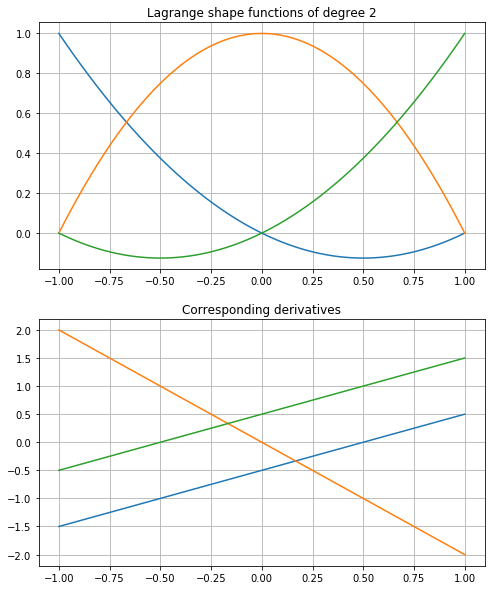

In [5]:
fig = plt.figure(figsize=(8, 10))
axes = fig.subplots(2, 1)
(ax1, ax2) = axes 

svec = np.linspace(-1,1,100)

for i in range(shapefun.d + 1):
    ax1.plot(svec, shapefun.eta[i](svec))
    ax2.plot(svec, shapefun.Deta[i](svec))
    
ax1.grid()
ax1.set(title='Lagrange shape functions of degree ' + str(shapefun.d))
ax2.grid()
ax2.set(title='Corresponding derivatives')

plt.show()

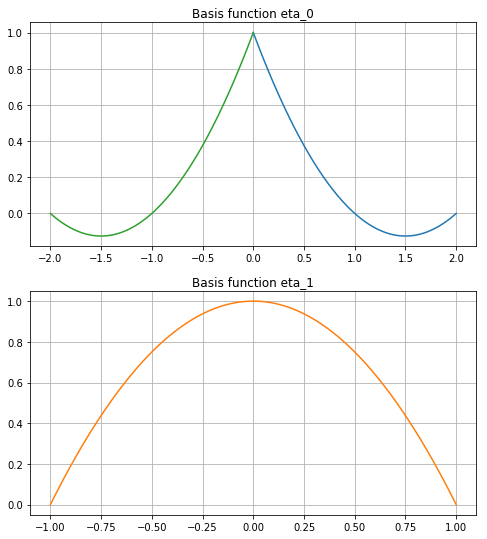

In [6]:
fig = plt.figure(figsize=(8, shapefun.d*6 + 2 ))
axes = fig.subplots(shapefun.d + 1, 1) 

for i in range(shapefun.d + 1):
    
    if i == shapefun.d:
        axes[0].plot(svec - shapefun.s[i], shapefun.eta[i](svec), color='C' + str(i))
    else:
        axes[i].plot(svec - shapefun.s[i], shapefun.eta[i](svec), color='C' + str(i))
        axes[i].grid()
        axes[i].set(title='Basis function eta_' + str(i))

fig.delaxes(axes[shapefun.d])
plt.show()

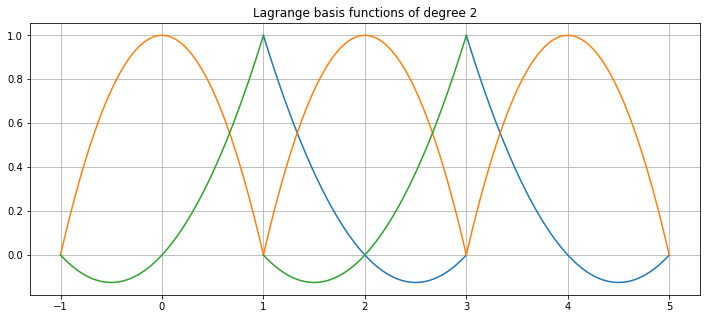

In [7]:
fig = plt.figure(figsize=(12, 5))
ax = fig.subplots()

for i in range(shapefun.d + 1):
    
    if i == 0:
        ax.plot(svec + 2, shapefun.eta[i](svec), color='C' + str(i))
        ax.plot(svec + 4, shapefun.eta[i](svec), color='C' + str(i))
    elif i == shapefun.d:
        ax.plot(svec, shapefun.eta[i](svec), color='C' + str(i))
        ax.plot(svec + 2, shapefun.eta[i](svec), color='C' + str(i))
    else:
        ax.plot(svec, shapefun.eta[i](svec), color='C' + str(i))
        ax.plot(svec + 2, shapefun.eta[i](svec), color='C' + str(i))
        ax.plot(svec + 4, shapefun.eta[i](svec), color='C' + str(i))
    
    
ax.grid()
ax.set(title='Lagrange basis functions of degree ' + str(shapefun.d))

plt.show()

## Global mass and stiffness matrices



In [8]:
el_b = np.linspace(-np.pi, np.pi, 2**4 + 1)
# element boundaries (defining the simulation domain including the domain boundaries)
# can be any 1D array with strictly increasing entries
print('len(el_b) =', len(el_b))
print()
for i in range(len(el_b)):
    print('el_b({0}) = {1:3.2f}'.format(i, el_b[i]))

Nel = len(el_b) - 1
print('\nNel =', Nel)
# number of elements
deg = shapefun.d
# polynomial degree
NN = Nel*(deg + 1) - (Nel - 1)
N0 = NN - 2 
N1 = NN - 1
# number of degrees of freedom (NN including the boundary)
print('\nNN =', NN)

# mesh points

len(el_b) = 17

el_b(0) = -3.14
el_b(1) = -2.75
el_b(2) = -2.36
el_b(3) = -1.96
el_b(4) = -1.57
el_b(5) = -1.18
el_b(6) = -0.79
el_b(7) = -0.39
el_b(8) = 0.00
el_b(9) = 0.39
el_b(10) = 0.79
el_b(11) = 1.18
el_b(12) = 1.57
el_b(13) = 1.96
el_b(14) = 2.36
el_b(15) = 2.75
el_b(16) = 3.14

Nel = 16

NN = 33


In [9]:
# Mass matrix assembly:

mass0 = np.zeros((N0, N0))
print(mass0)
print()
# initiate mass matrix

# left boundary:
mass0[:shapefun.d, :shapefun.d] = (el_b[1] - el_b[0])/2*shapefun.mass[1:, 1:]
index = shapefun.d - 1
print('i =', 0)
print(mass0[:index + 1, :index + 1])
print()

# bulk:
for i in np.arange(1, Nel - 1):
    mass0[index:index + shapefun.d + 1, index:index + shapefun.d + 1] += (
        (el_b[i + 1] - el_b[i])/2*shapefun.mass[:, :] )
    index += shapefun.d
    # remark the '+=' in mass0 for the cumulative sum for overlapping degrees of freedom
    if i == 1:
        print('i =', i)
        print(mass0[:index + 1, :index + 1])
        print()
    elif i == Nel - 2:
        print('i =', i)
        print(mass0[index - shapefun.d:, index - shapefun.d:])
        print()
    
# right boundary
mass0[index:index + shapefun.d, index:index + shapefun.d] += (
        (el_b[-1] - el_b[-2])/2*shapefun.mass[:-1, :-1] )
print('i =', Nel - 1)
print(mass0[index - shapefun.d:, index - shapefun.d:])
print()

print(mass0)

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 

In [10]:
# Stiffness matrix assembly:

stiff0 = np.zeros((N0, N0))
# initiate stiffness matrix

# left boundary:
stiff0[:shapefun.d, :shapefun.d] = 2/(el_b[1] - el_b[0])*shapefun.stiff[1:, 1:]
index = shapefun.d - 1

# bulk:
for i in np.arange(1, Nel - 1):
    stiff0[index:index + shapefun.d + 1, index:index + shapefun.d + 1] += (
        2/(el_b[i + 1] - el_b[i])*shapefun.stiff[:, :] )
    index += shapefun.d
    
# right boundary
stiff0[index:index + shapefun.d, index:index + shapefun.d] += (
        2/(el_b[-1] - el_b[-2])*shapefun.stiff[:-1, :-1] )

We want to test our implementation of the mass and stiffness matrices. In order to verify the mass matrix we test the $L^2$-projection. Let $E\in L^2((a,b))$ and denote by $\Lambda^2_0: L^2 \to V_0$ the $L^2$-projection on the finite dimensional subspace spanned by the basis functions $(\varphi_j^0)_{1 \leq j \leq N_0}$. The $L^2$-projection is defined by

$$
\be \label{L2proj}
 ( \Lambda^2_0 E - E,\, \varphi_j^0 )_{L^2} = 0 \qquad \forall\,\varphi_j^0\,.
\ee
$$

At the same time, we have

$$
\be
 (\Lambda^2_0 E)(x) = \sum_{i=1}^{N_0} e_i\,\varphi_i^0(x)\,,
\ee
$$

where $e = (e_i)_{1\leq i \leq N_0} \in \mathbb R^{N_0}$ holds the coefficients of the projected $E$ in the given basis. Moreover, we denote the mass matrix by $M^0 \in \mathbb R^{N_0 \times N_0}$ and define the vector $\overline E = (\overline E_j)_{1 \leq j \leq N_0} \in \mathbb R^{N_0}$ with $\overline E_j := (E,\,\varphi_j^0)_{L^2}$. With this, from \eqref{L2proj} we obtain

$$
\ba
 &( \Lambda^2_0 E,\, \varphi_j^0 )_{L^2} = ( E,\, \varphi_j^0 )_{L^2} \qquad \forall\,\varphi_j^0
 \\[1mm]
 &\Leftrightarrow\quad \sum_{i=1}^{N_0} e_i \int_a^b \varphi_i^0 \varphi_j^0\,\tn d x = \overline E_j \qquad \forall\,j   \nonumber
 \\[0mm]
 &\Leftrightarrow\quad \sum_{i=1}^{N_0} e_i \, M^0_{i,j} = \overline E_j \qquad \forall\,j  \nonumber
 \\[1mm]
 &\Leftrightarrow\quad (M^0)^\top \cdot e = \overline E   \nonumber
 \\[4mm]
 &\Leftrightarrow\quad e = (M^0)^{-1} \cdot \overline E \,.  \label{L2formula}
\ea
$$

To get to the last line we used that the mass matrix is symmetric. We shall compute the projection of a given function $E$ from formula \eqref{L2formula} and then compare $||\Lambda^2_0 E - E||_{L^2}$ for different degrees of polynomials and mesh resolution. For this we included the above assembly procedures as the function <i>fembase.lag_assemb</i> in the module _fembase.py_.

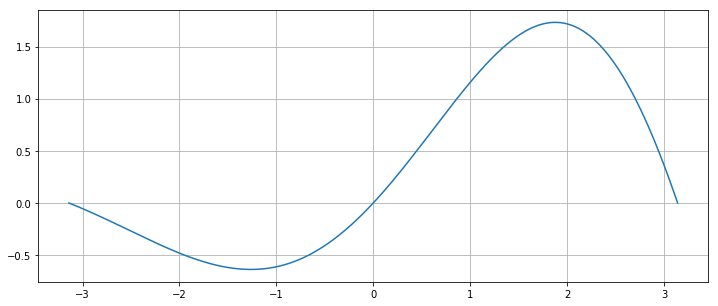

In [11]:
# The function we project:
Efun = lambda x: np.sin(x)*np.exp(x/np.pi)
xvec = np.linspace(-np.pi, np.pi, 500)
fig = plt.figure(figsize=(12, 5))
ax = fig.subplots()
ax.plot(xvec, Efun(xvec))
ax.grid()

L2-error = 0.08776245986158916 degree = 1 Nel = 8
L2-error = 0.018972808669397986 degree = 1 Nel = 16
L2-error = 0.004449130124062874 degree = 1 Nel = 32
L2-error = 0.0010805290621008297 degree = 1 Nel = 64
L2-error = 0.0002664441301781021 degree = 1 Nel = 128


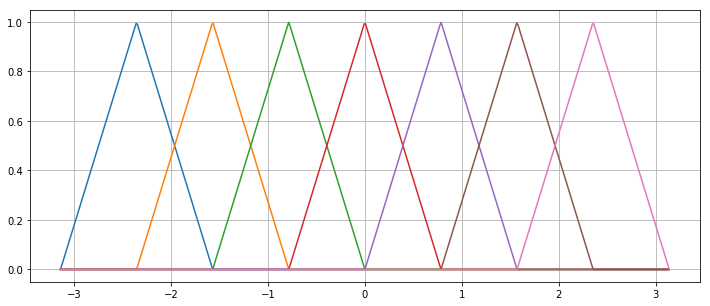

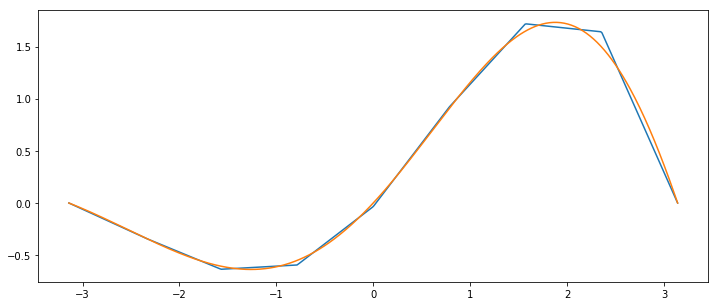

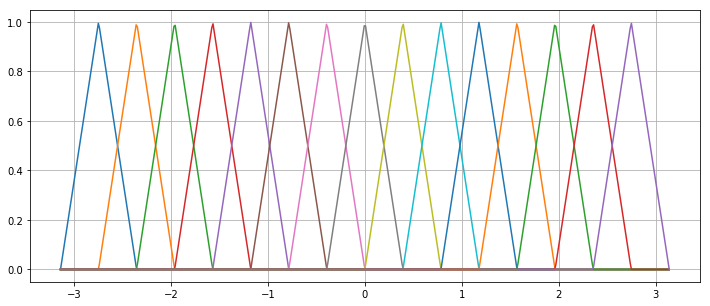

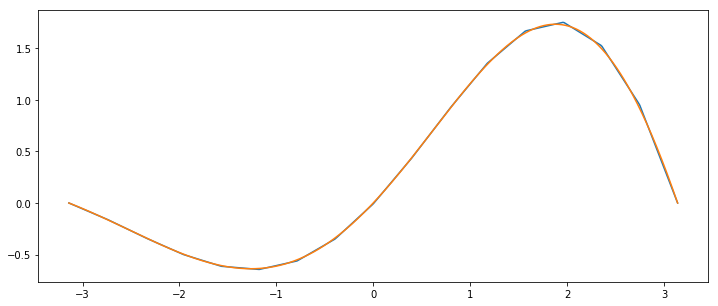

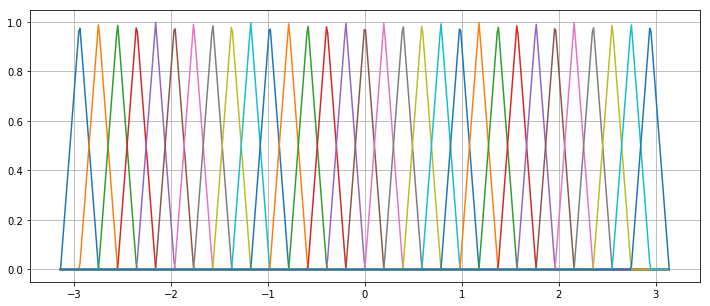

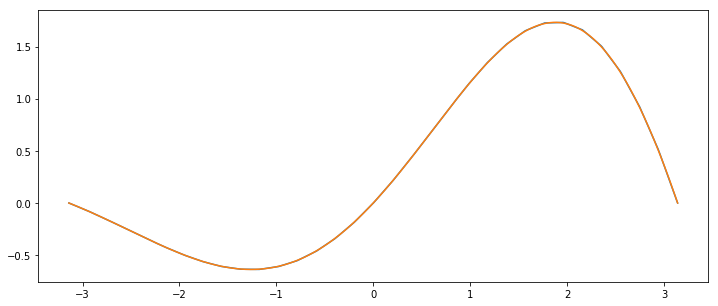

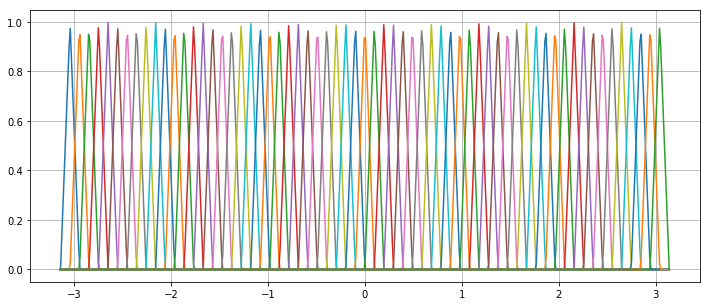

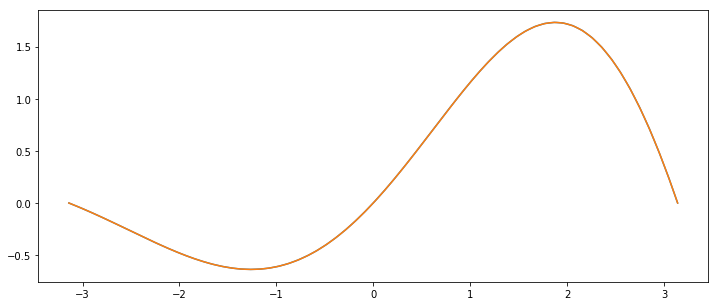

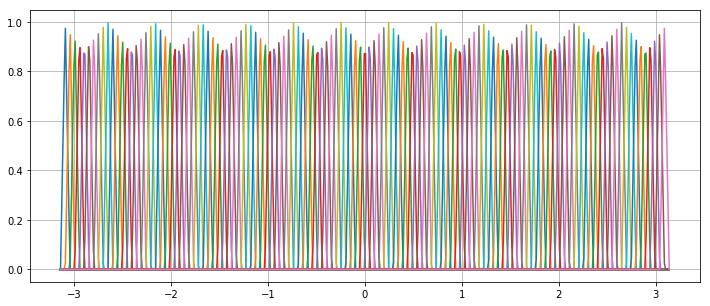

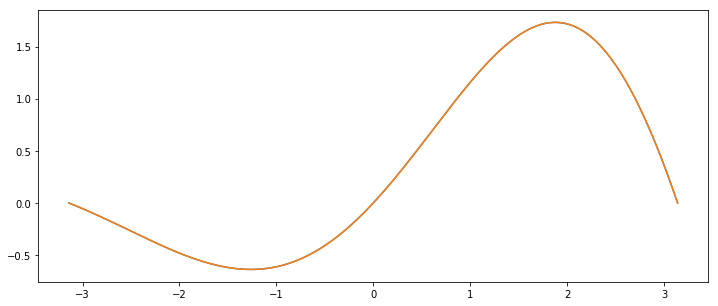

In [15]:
degree = 1
shapefun = fem.LagrangeShape(np.linspace(-1, 1, degree + 1))
# the object holding the Lagrange shape functions

# loop over different number of elements (mesh resolution):
cases = 5
L2error = np.zeros(cases)
Nel_vec = np.zeros(cases)
for i in range(3, 3 + cases):
    
    el_b = np.linspace(-np.pi, np.pi, 2**i + 1)
    
    Nel, Nbase, Ebar = fem.lag_L2prod(Efun, shapefun.eta, el_b)
    
    Nel, Nbase, mass, stiff = fem.lag_assemb(el_b, shapefun.mass, shapefun.stiff)
    
    evec = np.linalg.solve(mass, Ebar)
    testvec = np.zeros(Nbase) 
    
    fig = plt.figure(figsize=(12, 5))
    ax1 = fig.subplots()
    fig = plt.figure(figsize=(12, 5))
    ax2 = fig.subplots()
    
    for j in range(Nbase):   
        testvec[:] = 0 
        testvec[j] = 1
        # coeficients of the projection

        Nel, Nbase, basefun = fem.lag_fun(testvec, shapefun.eta, el_b)
        
        ax1.plot(xvec, basefun(xvec))
        ax1.grid()
        
    Nel, Nbase, Eproj = fem.lag_fun(evec, shapefun.eta, el_b)

    ax2.plot(xvec, Eproj(xvec))
    ax2.grid()

    ax2.plot(xvec, Efun(xvec))
    ax2.grid()
        
    # L2-error:
    Nel_vec[i - 3] = Nel
    L2error[i - 3] = 0
    integrand = lambda x: abs(Eproj(x) - Efun(x))**2
    for k in range(Nel):
        L2error[i - 3] += fixed_quad(integrand, el_b[k], el_b[k + 1])[0]

    L2error[i - 3] = np.sqrt(L2error[i - 3 ]) 
    print('L2-error =', L2error[i - 3], 'degree =', degree, 'Nel =', Nel)
    

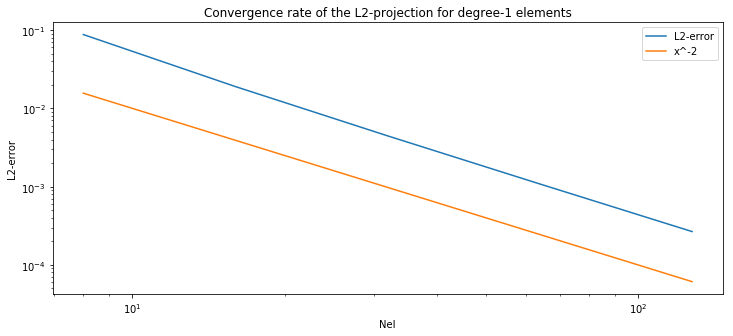

In [16]:
fig = plt.figure(figsize=(12, 5))
ax = fig.subplots()
ax.loglog(Nel_vec, L2error, label='L2-error')
ax.loglog(Nel_vec, Nel_vec**(-(degree + 1)), label='x^' + str(-degree-1))
ax.set(title='Convergence rate of the L2-projection for degree-' + str(degree) 
       + ' elements', xlabel='Nel', ylabel='L2-error')
ax.legend()